In [1]:
# Import libraries 

import numpy as np
import cv2 as cv
import pandas as pd
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt

In [2]:
#Reading the image
img = cv.imread('Resources/Train_images/Sandstone_Versa0000.tif', 0)
img2= img.reshape(-1)

In [4]:
# Creating the dataframe and adding the features
df = pd.DataFrame()

df['Original Image'] = img2 #Feature #1 (Original pixel value)

In [5]:
# Gabor features
ksize = 5
phi = 0
num = 1 # count for labelling
kernels = []
for theta in range(2): #Define number of thetas
    theta = theta /4. *np.pi
    for sigma in (1,3): #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi/4): #Range of wavelengths
            for gamma in (0.05, 0.5): # Gamma values of 0.05 and 0.5
                gabor_label ='Gabor' + str(num)
                kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv.CV_32F)
                kernels.append(kernel)
                fimg = cv.filter2D(img,cv.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img
                num += 1
                


In [6]:
### Canny Edge Feature
edges = cv.Canny(img, 100,200).reshape(-1)
df['Canny Edge'] = edges

In [7]:
# Roberts Feature 
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

In [8]:
# Sobel Feature
sobel_img = sobel(img)
sobel1 = sobel_img.reshape(-1)
df['Sobel'] = sobel1

In [9]:
# Scharr Feature 
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

In [10]:
# Prewitt Feature 
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

In [11]:
# Gaussian Features
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian1

In [12]:
gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian3 = gaussian_img.reshape(-1)
df['Gaussian s7'] = gaussian3

In [13]:
# Median Feature
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

In [14]:
# Variance Feature
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1

In [15]:
# Adding the labeled image
labeled_img = cv.imread('Resources/Train_masks/Sandstone_Versa0000.tif', 0)
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

In [16]:
# Splitting the data 
y = df['Labels'].values
x = df.drop(['Labels'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4, random_state=20)

In [17]:
# Train the model
model = LinearSVC(max_iter=1000, )
model.fit(x_train, y_train)

C:\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [18]:
# Prediction
prediction_test = model.predict(x_test)
print('Accuracy: ', metrics.accuracy_score(y_test, prediction_test))

Accuracy:  0.9546796025119987


In [20]:
# Feature Ranking
'''
importances = list(model.feature_importances_)
features_list = list(x.columns)
features_importance = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print(features_importance)'''

'\nimportances = list(model.feature_importances_)\nfeatures_list = list(x.columns)\nfeatures_importance = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)\nprint(features_importance)'

In [21]:
# Pickling the model
filename = 'Results/SVM_sandstone_model'
pickle.dump(model, open(filename, 'wb'))

In [22]:
# Loading the model and use it
load_model = pickle.load(open(filename, 'rb'))
result = load_model.predict(x)

In [23]:
segmented = result.reshape(img.shape) #Reshaping the results

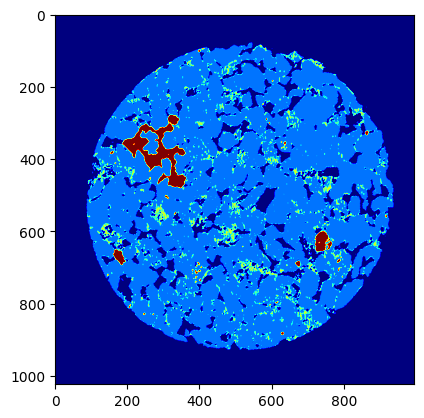

In [24]:
# Plotting the results
plt.imshow(segmented, cmap='jet')
plt.imsave('Results/SVM_segmented_rock.jpg', segmented, cmap='jet')